# Стилизация при помощи Adaptive Instance Normalization

Оригинальная статья: https://openaccess.thecvf.com/content_ICCV_2017/papers/Huang_Arbitrary_Style_Transfer_ICCV_2017_paper.pdf

#### Задача: имплементация архитектуры из статьи, обучение и сравнение с алгоритмом Гатиса.

## Идея

![](./architecture.jpg)

<font size="4">
    <ol>
        <li> Используем первые слои VGG-19 в качестве энкодера. Получаем карты признаков для изображений контента и стиля.</li>
        <li> Для каждого канала полученных карт признаков в отдельности считаем среднее значение и стандартное отклонение. </li>
        <li> Нормализуем (меняем распределение) карт признаков контента согласно полученным статистикам для стиля. Получается перенос контента в распределение стиля. </li>
        <li> Преобразованные карты признаков нужно превратить снова в изображение, поэтому они подаются на вход в декодер, задача которого сгенерировать стилизованное трёхканальное изображение с исходными размерностями. </li>
        <li> Для обучение прогоняем полученную картинку снова через энкодер и считаем лосс по выходам энкодера. </li>
    </ol>
</font>

### 0. Импорты

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import vgg19
from PIL import Image

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

## 1. Энкодер

В оригинальной статье бралась вся модель вплоть до Relu_4_1. Это 20-й слой сети VGG19. Сделаем так же.

In [7]:
vgg = vgg19(True).features[:21]

for param in vgg.parameters():
    param.requires_grad = False
    
vgg

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

* блок-1: 0 - 4
* блок-2: 5 - 9
* блок-3: 10 - 18
* блок-4: 19 - 20

<font size="4">Потеря стиля в оригинальной статье считается после слоёв relu_1_1, relu_2_1, relu_3_1, relu_4_1, поэтому нужно иметь возможность получения выходов с каждого из этого слоя для рассчёта лосса.</font>

In [10]:
class Encoder(nn.Module):
    def __init__(self, base_cnn: nn.Sequential):
        super(Encoder, self).__init__()
        self.encoder = base_cnn

    def forward(self, inp, return_all_outputs=False):
        outp1 = self.encoder[:2](inp) # relu_1_1
        outp2 = self.encoder[2:7](outp1) # relu_2_1
        outp3 = self.encoder[7:12](outp2) # relu_3_1
        outp4 = self.encoder[12:21](outp3) # relu_4_1

        # для подсчёта потери стиля
        if return_all_outputs:
            return outp1, outp2, outp3, outp4
            
        return outp4    

## 2. AdaIN

- <font size="4"> блок Adaptive Instance Normalization, который получает `content_feature_maps` и `style_feature_maps`, рассчитывает для них векторы средних и стандартных отклонений (для каждого канала в отдельности), и приводит распределение `content_feature_maps` к распределению `style_feature_maps`. </font>

![](adain.jpg)

In [14]:
# Игрушечный пример расчёта mean и std для батча изображений
test = torch.tensor([
    [
        [
            [1, 2, 3, 4, 5],
            [5, 4, 3, 2, 1],
            [11, 12, 13, 14, 15]
        ],
        [
            [1, 2, 3, 4, 5],
            [5, 4, 3, 2, 1],
            [11, 12, 13, 14, 15]
        ],
        [
            [1, 1, 1, 0, 0],
            [0, 0, -35, 2, 1],
            [0, 500, 0, 11, 0]
        ]
    ]
], dtype=torch.float)

batch_size = test.size()[0]
channels = test.size()[1]
h = test.size()[2]
w = test.size()[3]

display(test.reshape(batch_size, channels, -1).mean(dim=2).reshape(batch_size, channels, 1, 1))
print()
display(test.reshape(batch_size, channels, -1).std(dim=2).reshape(batch_size, channels, 1, 1))

tensor([[[[ 6.3333]],

         [[ 6.3333]],

         [[32.1333]]]])

tensor([[[[  5.0943]],

         [[  5.0943]],

         [[129.7981]]]])

In [15]:
class MeanStdCalculator(nn.Module):
    """
    Модуль подсчёта среднего значения и стандартного отклонения по каждому каналу.
    Пригодится в блоке AdaIN, а также при вычислении потери стиля.
    """
    def __init__(self):
        super(MeanStdCalculator, self).__init__()

    def forward(self, feature_maps: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        batch_size = feature_maps.size()[0]
        channels = feature_maps.size()[1]
        
        mean = feature_maps.reshape(batch_size, channels, -1).mean(dim=2).reshape(batch_size, channels, 1, 1)
        std = feature_maps.reshape(batch_size, channels, -1).std(dim=2).reshape(batch_size, channels, 1, 1)

        return mean, std
        

class AdaIN(nn.Module):
    """
    Модуль адаптивной инстанс нормализации.
    Преобразует карты признаков контента согласно распределения карт признаков для стиля.
    """
    def __init__(self):
        super(AdaIN, self).__init__()
        self.mean_std_calc = MeanStdCalculator()
        
    def forward(self, content_features, style_features) -> torch.Tensor:
        content_mean, content_std = self.mean_std_calc(content_features)
        style_mean, style_std = self.mean_std_calc(style_features)

        norm_content = (content_features - content_mean) / content_std
        adapt_content = norm_content * style_std + style_mean

        return adapt_content

In [16]:
adapt_test = AdaIN()(test, test)
adapt_test

tensor([[[[  1.0000,   2.0000,   3.0000,   4.0000,   5.0000],
          [  5.0000,   4.0000,   3.0000,   2.0000,   1.0000],
          [ 11.0000,  12.0000,  13.0000,  14.0000,  15.0000]],

         [[  1.0000,   2.0000,   3.0000,   4.0000,   5.0000],
          [  5.0000,   4.0000,   3.0000,   2.0000,   1.0000],
          [ 11.0000,  12.0000,  13.0000,  14.0000,  15.0000]],

         [[  1.0000,   1.0000,   1.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000, -35.0000,   2.0000,   1.0000],
          [  0.0000, 500.0000,   0.0000,  11.0000,   0.0000]]]])

## 3. Decoder

После блока AdaIN мы получаем выход t - нормализованные по параметрам стиля карты признаков. После этого данное представление t нужно восстановить до исходного размера изображений, получив стилизацию. 

В статье было предложено использовать в декодере nearest-upsampling для того, чтобы избегать появления артефактов на выходном изображении. 

In [19]:
# Сформируем правильную последовательность Upsampling для восстановления исходного размра изображения

# 1. Возьмем тестовую картинку и приведем ее к размеру 512х512
test_img = Image.open("../online-nst/data/contents/dancing.jpg").resize((512, 512))
test_img = transforms.ToTensor()(test_img).unsqueeze(0)

# 2. Прогоним её через слои VGG-19, чтобы увидеть, как меняются ее размерности 
# с каждым max-pool размерность должна уменьшаться вдвое, а свертка с kernel_size=3, padding=1, stride=1 не должна менять размер. Проверим:
print(f"Исходная размерность: {test_img.size()}")

pool1 = vgg[:5](test_img)
print(f"pool1: {pool1.size()}")

pool2 = vgg[5:10](pool1)
print(f"pool2: {pool2.size()}")

pool3 = vgg[10:](pool2)
print(f"pool3: {pool3.size()}")

Исходная размерность: torch.Size([1, 3, 512, 512])
pool1: torch.Size([1, 64, 256, 256])
pool2: torch.Size([1, 128, 128, 128])
pool3: torch.Size([1, 512, 64, 64])


In [20]:
# 3. Добавим последовательность upsample блоков для восстановления размерности. Для регулирования количества каналов используем Conv2d
upsample = nn.Upsample(scale_factor=2, mode='nearest')
conv1 = nn.Conv2d(512, 128, kernel_size=3, stride=1, padding=1)
conv2 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
conv3 = nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)

result = conv3(upsample(conv2(upsample(conv1(upsample(pool3))))))
print(f"Выходная размерность {result.size()}")

assert result.size() == test_img.size(), "Размерности должны были совпасть"

Выходная размерность torch.Size([1, 3, 512, 512])


Теперь можно реализовывать декодер...

In [22]:
class Decoder(nn.Module):
    """
    Декодер должен хорошо научиться восстанавливать изображения,
    для этого понадобится использовать бОльшее количество свёрток чем 3.
    """
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest')
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest')
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, inp):
        return self.block3(self.block2(self.block1(inp)))

In [23]:
encoded = vgg(test_img)
decoded = Decoder()(encoded)

decoded.size()

torch.Size([1, 3, 512, 512])

## 4. Модель. Лоссы.

In [25]:
class AdainStyleTransferModel(nn.Module):
    def __init__(self, base_cnn: nn.Sequential):
        super(AdainStyleTransferModel, self).__init__()
        self.encoder = Encoder(base_cnn=base_cnn)
        self.adain = AdaIN()
        self.decoder = Decoder()
        self.mean_std_calc = MeanStdCalculator()

    
    def stylize(self, content: torch.Tensor, style: torch.Tensor, alpha: float = 1.0):
        """
        Функция стилизации, которая будет применяться при инференсе.
        * alpha - число [0, 1], степень переноса стиля
        """
        content_features = self.encoder(content, return_all_outputs=False) # карты признаков контента с последнего слоя энкодера 
        style_features = self.encoder(style, return_all_outputs=False) # карты признаков стиля с последнего слоя энкодера
        
        adain_features = self.adain(content_features, style_features) # модифицированные карты признаков контента (стилизованные)
        adain_features = alpha * adain_features + (1 - alpha) * content_features # контроль степени стилизации при помощи alpha
        
        outp = self.decoder(adain_features) # получение стилизованного изображения исходного (512х512) размера
        
        return outp


    def __content_loss(self, result_enc_outp, adain_features):
        """
        * result_enc_outp - выход энкодера для D(adain_content), где D - декодер
        * adain_content - выход блока AdaIN, преобразованные фичи изначального контент-изображения
        """
        return torch.nn.functional.mse_loss(result_enc_outp, adain_features)

    
    def __style_loss(self, result_enc_outputs, style_enc_outputs):
        """
        * result_enc_outputs - выходы всех рассмотренных выше слоев энкодера для полученной декодером стилизации
        * style_enc_outputs - выходы всех рассмотренных выше слоев энкодера для изображения стиля
        """
        style_loss_ = 0.0
        for result_outp, style_outp in zip(result_enc_outputs, style_enc_outputs):
            result_outp_mean, result_outp_std = self.mean_std_calc(result_outp)
            style_outp_mean, style_outp_std = self.mean_std_calc(style_outp)

            style_loss_ += nn.functional.mse_loss(result_outp_mean, style_outp_mean) + nn.functional.mse_loss(result_outp_std, style_outp_std)
            
        return style_loss_
        

    def forward(self, content_images, style_images, alpha=1.0, style_weight=10):
        content_features = self.encoder(content_images)
        style_features = self.encoder(style_images)
        
        adain_features = self.adain(content_features, style_features)
        adain_features = alpha * adain_features + (1 - alpha) * content_features
        
        result = self.decoder(adain_features)                 

        result_features = self.encoder(result, return_all_outputs=False)    
        result_all_features = self.encoder(result, return_all_outputs=True)   
        style_all_features = self.encoder(style_images, return_all_outputs=True)   

        content_loss = self.__content_loss(result_features, adain_features)     
        style_loss = self.__style_loss(result_all_features, style_all_features)  
        loss = content_loss + style_weight * style_loss
        return loss

In [26]:
model = AdainStyleTransferModel(vgg)
model

AdainStyleTransferModel(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inpla

In [27]:
loss = model(test_img, test_img)

In [28]:
loss

tensor(13.1679, grad_fn=<AddBackward0>)

In [29]:
import time
a = time.time()
model.stylize(test_img, test_img)
b = time.time()

In [30]:
b - a

2.2000644207000732

## 5. Функции обучения модели.

In [48]:
def train_epoch(model, optimizer, content_loader, style_loader, checkpoints_path):
    pass

In [ ]:
from tqdm.auto import tqdm

def train(model, optimizer, scheduler, 
          content_loader: torch.utils.data.DataLoader, style_loader: torch.utils.data.DataLoader, 
          num_steps: int, checkpoints_path: str = "./models", save_freq: int = 1000):
    """
    Параметры:
    * model - модель переноса стиля с замороженными слоями энкодера
    * optimizer - оптимизатор декодера модели 
    * scheduler - выполняет уменьшение learning_rate каждые 100 итерации, если не None
    * content_loader, style_loader - дата лоадеры
    * num_steps - количество эпох
    * checkpoint_path - путь до папки с чекпойтами модели
    * save_freq - частота сохранения модели, default=1000 - сохранять состояние модели каждые 1000 итераций
    """
    losses_list = []
    
    for step in tqdm(range(num_steps)):
        # train one epoch
        epoch_loss = train_epoch(model, optimizer, content_loader, style_loader, checkpoints_path, save_freq)
        epoch_

## 6. Датасет. Загрузка и предобработка.

In [20]:
from torch.utils.data import Dataset
import torchvision.transforms as transforms

In [139]:
import os
from PIL import Image

IMSIZE = (512, 512)

contents_directory = "../online-nst/data/contents/"
styles_directory = "../online-nst/data/styles/"

content_names = os.listdir(contents_directory) 
style_names = os.listdir(styles_directory)

content_paths = [contents_directory + i for i in content_names]
style_paths = [styles_directory + i for i in style_names]

In [197]:
class ImagesDataset(Dataset):
    """
    !!! Важно учесть наличие четвёртой размерности у некоторых картинок, потому что на них ломается нормализация !!!
    Датасет изображений из MSCOCO.

    Нужно провести следующие преобразования над изображениями:
    * resize -> (512, 512)
    * нормализация согласно значениям из ImageNet
    * преобразование к тензору
    """

    def __init__(self, files: list[str]):
        super(ImagesDataset, self).__init__()
        
        self.files = sorted(files)
        self.len_ = len(self.files)
        
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])


    def __len__(self):
        return self.len_


    def load_sample(self, file):
        with Image.open(file) as image:
            image.load()
            return image.resize(IMSIZE)


    def __getitem__(self, index):
        x = self.load_sample(self.files[index])
        x = self.transform(x)

        return x

In [199]:
cd = ImagesDataset(content_paths)
sd = ImagesDataset(style_paths[3:])
c_iter = iter(cd)
s_iter = iter(sd)

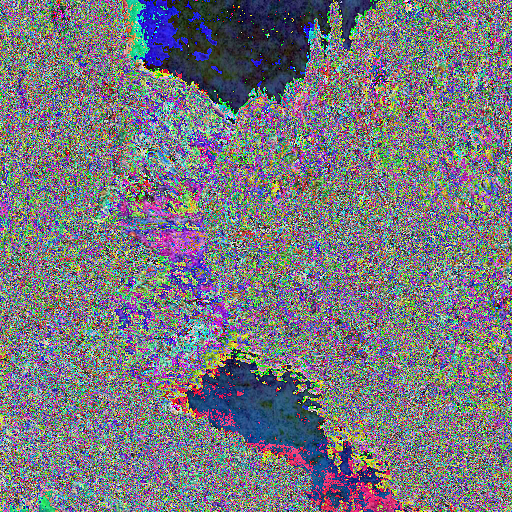

In [201]:
transforms.ToPILImage()(next(s_iter))

In [ ]:
"""
Потом формируем даталоадеры, создаем модель, оптимизатор, скеджулер и обучение.
Для начала дореализовать код загрузки и обработки данных, добавить функцию денормализации

Затем реализовать код обучения, с построением графиков лосса, сохранением состояния модели и оптимизатора, чтобы всё по красоте.

Протестировать работоспособность на небольшом количестве данных.
"""

## 7. Обучение и сохранение модели.